## Data Wrangling

In [7]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [10]:
# Create a list to hold data
data_list = []

# Define classes
data_path = '/Users/renatoboemer/code/edge/raw_data'
for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    
    # Check if the item is a directory
    if os.path.isdir(folder_path):
        for image in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image)
            label = folder
            data_list.append({'image_path': image_path, 'label': label})

# Convert list to DataFrame
data = pd.DataFrame(data_list)


In [11]:
data.head()

,image_path,label
0,/Users/renatoboemer/code/edge/raw_data/cloudy/...,cloudy
1,/Users/renatoboemer/code/edge/raw_data/cloudy/...,cloudy
2,/Users/renatoboemer/code/edge/raw_data/cloudy/...,cloudy
3,/Users/renatoboemer/code/edge/raw_data/cloudy/...,cloudy
4,/Users/renatoboemer/code/edge/raw_data/cloudy/...,cloudy


In [12]:
print('Labels: ', data.label.unique())
classes = data.label.unique()
data['label'].value_counts()

Labels:  ['cloudy' 'water' 'green_area' 'desert']


label
cloudy        1500
water         1500
green_area    1500
desert        1131
Name: count, dtype: int64

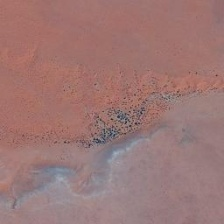

In [13]:
import cv2
from IPython.display import display, Image

# Specify the path to your image
image_path = '/Users/renatoboemer/code/edge/raw_data/desert/desert(57).jpg'

# Read the image
img = cv2.imread(image_path)

# Check if the image was loaded successfully
if img is None:
    print("Error: Couldn't load the image.")
else:
    # Display the image in the notebook
    display(Image(data=cv2.imencode('.jpg', img)[1].tobytes()))


In [14]:
# Printing the size (height, width, channels)
print("image dimensions:", img.shape)

image dimensions: (224, 224, 3)


In [14]:
def resize_images_in_directory(main_directory, target_size=(224, 224)):
    """
    Resize all images in the given directory and its sub-directories to the target size.

    :param main_directory: Path to the main directory.
    :param target_size: Tuple indicating target size (width, height).
    """
    
    resized = False  # Flag to indicate if any images were resized
    
    for root, dirs, files in os.walk(main_directory):
        for file in files:
            # Check if the file is an image (e.g., has a .jpg or .png extension).
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                
                # Read and resize the image
                img = cv2.imread(image_path)
                if img is not None:  # Check if image was loaded successfully
                    resized_img = cv2.resize(img, target_size)
                    
                    # Save the resized image back to the same path, effectively replacing it
                    cv2.imwrite(image_path, resized_img)
                    resized = True  # Set the flag to indicate that at least one image was resized

    if resized:
        print("Resizing complete.")
    else:
        print("No images were resized.")


In [15]:
main_directory = "/Users/renatoboemer/code/edge/raw_data"
resize_images_in_directory(main_directory, target_size=(224, 224))

Resizing complete.


In [15]:
def normalize_images(main_directory):
    """
    Normalize pixel values of all images in the given directory and its sub-directories to the [0, 1] range.
    """
    
    normalized = False  # Initialize a flag to check if any images were normalized

    for root, dirs, files in os.walk(main_directory):
        for file in files:
            # Check if the file is an image (e.g., has a .jpg or .png extension).
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)

                # Read the image
                img = cv2.imread(image_path)
                if img is not None:  # Check if image was loaded successfully
                    # Normalize pixel values to the [0, 1] range
                    img_normalized = img.astype(np.float32) / 255.0

                    # Save the normalized image (optional)
                    cv2.imwrite(image_path, (img_normalized * 255).astype(np.uint8))

                    normalized = True  # Set the flag to indicate that at least one image was normalized

    if normalized:
        print("Normalization complete.")
    else:
        print("Images not normalized.")


In [16]:
main_directory = "/Users/renatoboemer/code/edge/raw_data"
normalize_images(main_directory)

Normalization complete.


In [17]:
data.head()

,image_path,label
0,/Users/renatoboemer/code/edge/raw_data/cloudy/...,cloudy
1,/Users/renatoboemer/code/edge/raw_data/cloudy/...,cloudy
2,/Users/renatoboemer/code/edge/raw_data/cloudy/...,cloudy
3,/Users/renatoboemer/code/edge/raw_data/cloudy/...,cloudy
4,/Users/renatoboemer/code/edge/raw_data/cloudy/...,cloudy


In [18]:
train_df, val_test_df = train_test_split(data, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, random_state=42)

In [19]:
print("Number of training samples: ", train_df.shape[0])
print("Number of validation samples: ", val_df.shape[0])
print("Number of testing samples: ", test_df.shape[0])

Number of training samples:  4504
Number of validation samples:  563
Number of testing samples:  564


## Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Define input shape
input_shape = (224, 224, 3)

# Create MobileNetV3-Small model
base_model = MobileNetV3Small(input_shape=input_shape, include_top=False, weights='imagenet')

# Add custom classification layers on top
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [ ]:
model.summary()

In [ ]:
# Optional: Train the model with your dataset
# Replace 'train_data' and 'validation_data' with your own datasets
# model.fit(train_data, validation_data=validation_data, epochs=num_epochs)
